# PRAC 2: Modelatge dels preus del lloguer

Aquesta pràctica parteix de les dades preparades en la PRAC1. Un cop entès i fet el pre-processament del conjunt de dades ara ens enfoquem en aplicar una sèrie d'algorismes supervisats i no supervisats i a comparar-ne els resultats. 

En el cas dels algorismes no supervisats s'intentarà classificar la localització dels apartaments del dataset en grans zones geogràfiques arreu dels Estats Units. Per fer-ho s'aplicaran diversos models de clustering i se'n compararan els resultats.

Per a la segona part de la pràctica es posarà el focus en la classificació de les dades mitjançant algorismes supervisats per tal d'intentar crear un model capaç de categoritzar les ofertes entre les de preus "Baixos", "Mitjans", "Mitjans-Alts" i "Alts". Els models utilitzats seran els arbres de decisió, amb i sense poda i el gradient boosting.

In [168]:
#Import libraries
import pandas as pd
import numpy as np
import warnings
np.warnings = warnings
from matplotlib import pyplot as plt
import pandas as pd
from scipy import stats
import seaborn as sns

In [169]:
#Import data
df_rent = pd.read_csv(r"/home/JM/Desktop/Master/Mineria de Dades/PRAC1/PRAC1_Data")
#Get sample data
data = df_rent.sample(40000, random_state = 555)

## Models no supervisats

### Introducció
Com a recordatori, a la pràctica 1 es va estudiar la localització dels apartaments en relació al preu. Per fer-ho es va fer servir un hexplot que es reprodueix a continuació. Aquest permet considerar agrupacions d'apartaments i assignar-los un color en funció del preu mitjà amb l'objectiu d'identificar zones on els preus son més elevats i d'altres en que són més baixos. El que es persegueix mitjançant la creació de diversos models de clustering és intentar segmentar el territori en zones geogràfiques amb diferents mitjanes de preu. Cal remarcar que per aquesta pràctica i degut a temes relacionats amb els recursos computacionals i el temps d'execució dels algorismes, s'ha agafat una mostra representativa amb aproximadament el 50% dels registres del datset (40 000).

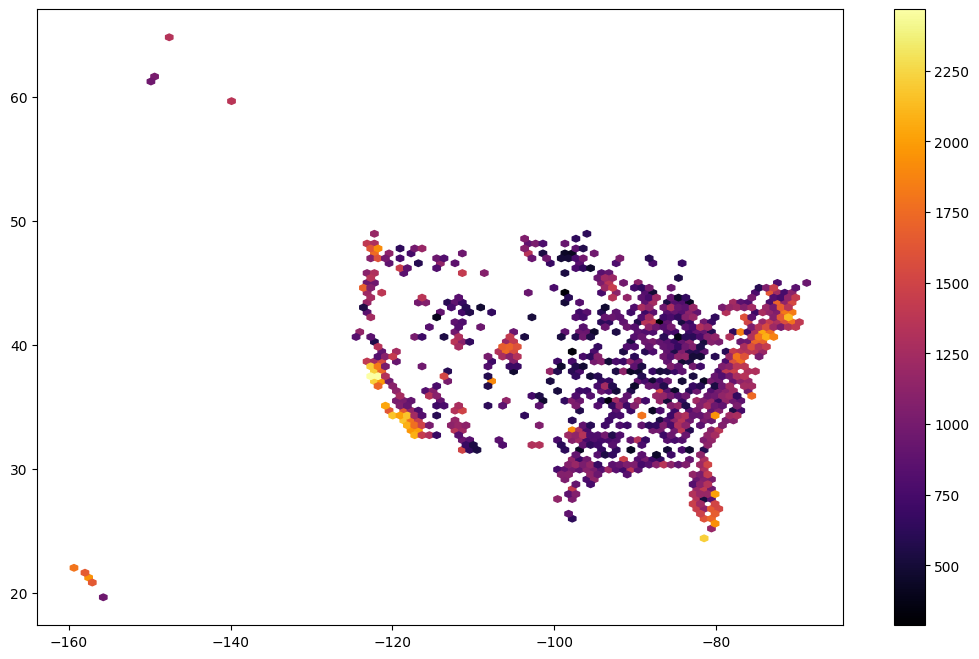

In [170]:
#Display Hexbin
plt.figure(figsize=(13,8))
plt.hexbin(df_rent["longitude"], df_rent["latitude"], gridsize = 100, cmap = 'inferno', mincnt = 1, C = df_rent["price"])
plt.colorbar()
plt.show()

### KMeans distància euclidiana
En primer lloc s'aplicarà l'algorisme KMeans amb distància euclidiana. En aquest cas, no fa falta normalitzar les variables malgrat fer servir l'algorisme K-means. Això no tendria sentit, ja que la longitud i la latitud perdrien el seu sentit geogràfic si els aplicam una normalització.

A continuació es pot visualitzar un "elbow plot" a partir dels valors de WCSS per diferents nombres de clústers. Tot i que segons aquesta tècnica el nombre òptim de clusters serien tres, es considera que per capturar les diferències entre el preu mitjà depenent de la zona geogràfica aquests no són suficients si es té en compte el hexplot presentat anteriorment. Per tant, s'ha decidit augmentar a 7 el nombre de clústers, ja que es considera que aquests aconsegueixen capturar de manera més adequada les diferències en el preu entre zones de costa i d'interior o entre grans zones metropolitanes i les zones menys densament poblades sense sobrecomplicar excessivament el model.

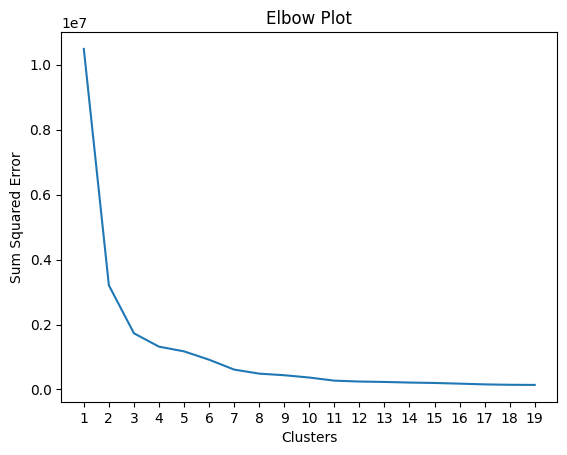

In [171]:
#Import library
from sklearn.cluster import KMeans

#Calculate WCSS
sum_sq_err = []
for clusters in range(1, 20):
    k_means = KMeans(n_clusters = clusters, random_state = 222)
    k_means.fit(data[["latitude","longitude"]])
    sum_sq_err.append(k_means.inertia_)

#Elbow plot
plt.plot(range(1, 20), sum_sq_err)
plt.xticks(range(1, 20))
plt.title("Elbow Plot")
plt.xlabel("Clusters")
plt.ylabel("Sum Squared Error")
plt.show()

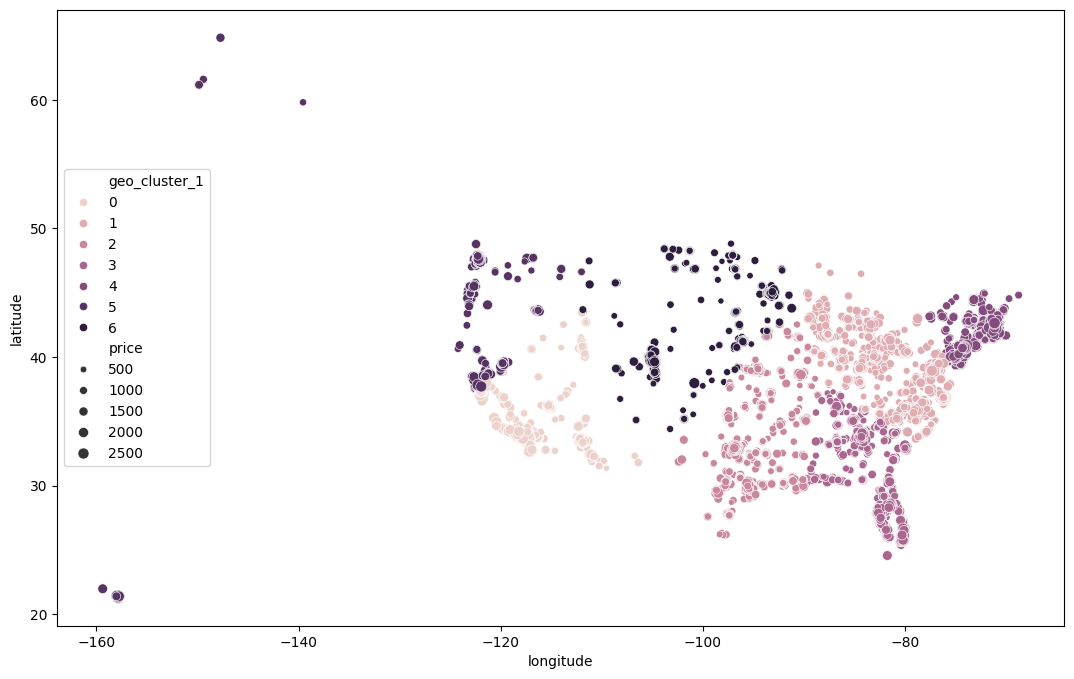

In [172]:
#KMeans 7 clusters
k_means = KMeans(n_clusters = 7, random_state = 222)
k_means.fit(data[["latitude","longitude"]])
clust_labels = k_means.predict(data[["latitude","longitude"]]).tolist()

#Add cluster labels to original df
data["geo_cluster_1"] = clust_labels

#Show plot
plt.figure(figsize=(13,8))
sns.scatterplot(x=data["longitude"], y=data["latitude"],size=data["price"], hue=data["geo_cluster_1"])
plt.show()

#### Avaluació del model
És important remarcar que el conjunt de dades no compta amb una variable que classifiqui els registres en diverses zones geogràfiques relacionades amb el preu idependentment de les fronteres estatals, i que, per tant, no comptem amb etiquetes que es pugui fer servir per avaluar el model mitjançant tècniques de validació externa. En lloc d'això, es faran servir la within cluster sum of squares i la silouette per comparar els resultats amb diferents nombres de clústers.

En analitzar els resultats d'aquestes mètriques es pot comprovar que, com és lògic la WCSS decreix amb l'increment del nombre de clústers. Pel que fa a la puntuació silouette, aquesta és més favorable com més elevats són els valors. En aquest cas s'han obtingut valors de 0.59 i 0.55 per models de 2 i 3 clústers respectivament. Pel model de 7 clústers, que és el que s'ha considerat més apropiat per reflectir les variacions en el preu sense sobrecomplicar excessivament el model, la silouette és de 0.51.

Finalment, es calcularan algunes mètriques adicionals com els índexs Davies Bouldin o Calinski Harabasz i s'emmagatzaran en una taula per poder realitzar comparacions amb altres models no supervisats.

In [173]:
#Import metrics libraries
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

#Calculate metrics values
for clusters in range(3, 8):
    k_means = KMeans(n_clusters = clusters, random_state = 222)
    k_means.fit(data[["latitude","longitude"]])
    clust_labels = k_means.predict(data[["latitude","longitude"]]).tolist()
    
    inert = k_means.inertia_
    silhouet = silhouette_score(data[["latitude","longitude"]], clust_labels)

    print(f'Clusters: {clusters}')
    print(f'WCSS: {inert}')
    print(f'Silhouette: {silhouet}')
    print("\n")

#Calculate additional metrics for Kmeans with seven clusters and store them in a df
k_means = KMeans(n_clusters = 7, random_state = 222)
k_means.fit(data[["latitude","longitude"]])
clust_labels = k_means.predict(data[["latitude","longitude"]]).tolist()
silhouet = silhouette_score(data[["latitude","longitude"]], clust_labels)
dav_bould = davies_bouldin_score(data[["latitude","longitude"]], clust_labels)
cal_hara = calinski_harabasz_score(data[["latitude","longitude"]], clust_labels)

#Sotore metrics in df
df_metrics = pd.DataFrame([silhouet,dav_bould,cal_hara], columns = ["Kmeans (euclid)"], index = ["Silhouette", "Davies Bouldin", "Calinski Harabasz"])

Clusters: 3
WCSS: 1730994.5065035862
Silhouette: 0.5504034267243355


Clusters: 4
WCSS: 1318611.8131996233
Silhouette: 0.4815540033400798


Clusters: 5
WCSS: 1173836.965208254
Silhouette: 0.4748149700039409


Clusters: 6
WCSS: 917050.7822008439
Silhouette: 0.4620954315945247


Clusters: 7
WCSS: 612611.0537450555
Silhouette: 0.5119258749725812




### KMeans distància de Manhattan
Com a variació sobre el model anterior s'ha aplicat de nou l'algorisme KMeans però aquesta vegada amb la distància de Manhattan. Simplement a partir de l'observació dels gràfics és fàcil observar que aquesta nova mètrica permet segmentar millor algunes zones geogràfiques distintives com és el cas de Florida. Tanmateix, per fer una anàlisi més profunda, s'han d'avaluar les mètriques numèriques.

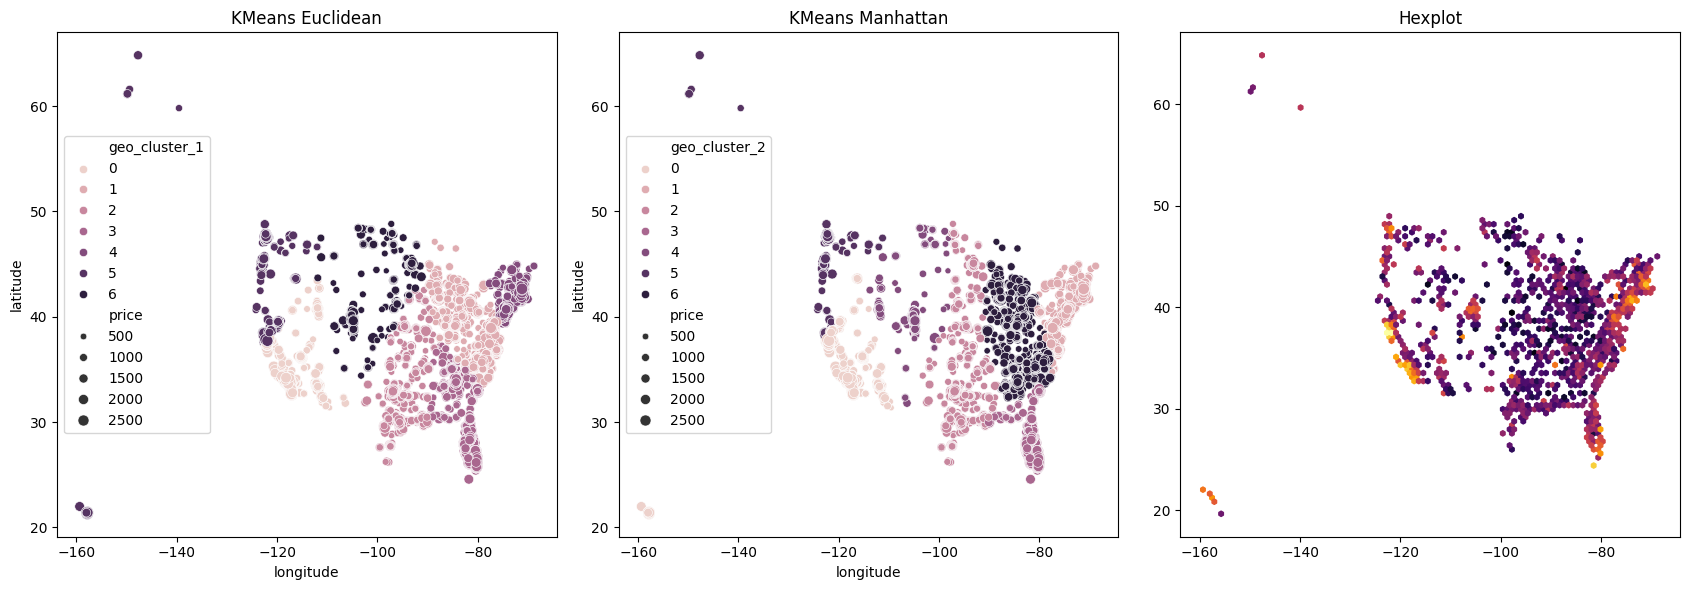

In [174]:
#Import libraries
from pyclustering.cluster.kmeans import kmeans
from pyclustering.cluster.center_initializer import kmeans_plusplus_initializer
from pyclustering.utils.metric import type_metric, distance_metric

#Set number of clusters
n_clusters = 7

#Initialize cluster centers
init_centers = kmeans_plusplus_initializer(data[["latitude","longitude"]], n_clusters, random_state = 222).initialize()

#Manhattan distance metric
manh_dist = distance_metric(type_metric.MANHATTAN)

#KMeans with Manhattan distance
k_means = kmeans(data[["latitude","longitude"]], init_centers, metric = manh_dist, random_state = 222)
k_means.process()
clusters = k_means.get_clusters()

#Add cluster labels to df
clust_labels = [0] * len(data[["latitude","longitude"]])

for clust_label, cluster in enumerate(clusters):
    for df_ind in cluster:
        clust_labels[df_ind] = clust_label

data['geo_cluster_2'] = clust_labels

#Show plot
fig, ax = plt.subplots(1, 3, figsize=(17, 6))
plt.hexbin(df_rent["longitude"], df_rent["latitude"], gridsize = 100, cmap = 'inferno', mincnt = 1, C = df_rent["price"])
sns.scatterplot(ax=ax[0], x=data["longitude"], y=data["latitude"], size=data["price"], hue=data["geo_cluster_1"])
sns.scatterplot(ax=ax[1], x=data["longitude"], y=data["latitude"], size=data["price"], hue=data["geo_cluster_2"])
ax[2].set_title('Hexplot')
ax[0].set_title('KMeans Euclidean')
ax[1].set_title('KMeans Manhattan')
plt.tight_layout()
plt.show()

#### Avaluació del model
Si comparem les puntuacions que han obtingut els dos models per les diferents mètriques, el KMeans que fa server la distància de Manhattan presenta millors puntuacions per totes tres mètriques. La Silhouette és la més elevada dels dos, l'índex Davis Bouldin el més baix, i la mètrica Calinski Harabasz la més elevada. El coeficient de Silhouette ens informa sobre com de bé estan agrupats els diferents datapoints en els seus grups, l´índex de Davies Bouldin ens aporta informació sobre si els grups més compactes i els centroides estan ben separats els uns dels altres. Finalment, líndex de Calinski Harabasz és una normalització del BCSS que ens indica si els grups estan ben separats entre si.

In [175]:
#Calculate metrics
silhouet = silhouette_score(data[["latitude","longitude"]], clust_labels)
dav_bould = davies_bouldin_score(data[["latitude","longitude"]], clust_labels)
cal_hara = calinski_harabasz_score(data[["latitude","longitude"]], clust_labels)

#Add metrics to df
df_metrics["Kmeans (Manhatt)"] = [silhouet,dav_bould,cal_hara]

In [176]:
#Show metrics df
df_metrics

,Kmeans (euclid),Kmeans (Manhatt)
Silhouette,0.511926,0.538339
Davies Bouldin,0.745586,0.588929
Calinski Harabasz,107402.992706,107788.718438


### DBSCAN

En aquest punt es provarà un model diferent de Kmean, basat en la densitat, el DBSCAN. Per modelar les dades de manera apropiada serà necessari determinar correctament els valors de eps i min_samples. Pel que fa al nombre mínim d'observacions en cada clúster, s'ha considerat adequat establir el llindar entorn de l'1% de les mostres. Aquesta decisió té avantatges i inconvenients. Per una banda, ens permet evitar que es generin clústers de poc interès, per l'altra és possible que les zones remotes amb insuficient oferta d'apartaments com Alaska o Hawaii passin a considerar-se com punts irrellevants o soroll.

A l'hora de determinar l'eps, s'ha creat un loop per examinar el nombre de clústers, el nombre de punts de soroll i la puntuació de silhouette de les diverses opcions. Es pot comprovar que la puntuació més elevada correspon al valor de eps = 2. En aquest cas es generen 8 clusters, un nombre proper al que hem obtingut amb el KMeans.

In [177]:
#Import libraries
from sklearn import metrics
from sklearn.cluster import DBSCAN

for eps in [0.3, 0.5, 1, 2, 3]:
    db = DBSCAN(eps = eps, min_samples = 500).fit(data[["latitude","longitude"]])
    clust_labels = db.labels_

    n_clusters_ = len(set(clust_labels)) - (1 if -1 in clust_labels else 0)
    n_noise_ = list(clust_labels).count(-1)
    
    print(f"EPS: {eps}")
    print(f"Clusters: {n_clusters_}")
    print(f"Noise: {n_noise_}")
    print(f"Silhouette: {silhouette_score(data[["latitude","longitude"]], clust_labels)}")
    print("\n")

EPS: 0.3
Clusters: 16
Noise: 17215
Silhouette: 0.17298450817638641


EPS: 0.5
Clusters: 18
Noise: 12196
Silhouette: 0.363350465158822


EPS: 1
Clusters: 15
Noise: 7228
Silhouette: 0.441847593763233


EPS: 2
Clusters: 8
Noise: 2222
Silhouette: 0.494204880521599


EPS: 3
Clusters: 4
Noise: 669
Silhouette: 0.46512659462795264




In [178]:
#Fit best    
db = DBSCAN(eps = 2, min_samples = 500).fit(data[["latitude","longitude"]])
clust_labels = db.labels_

n_clusters_ = len(set(clust_labels)) - (1 if -1 in clust_labels else 0)
n_noise_ = list(clust_labels).count(-1)

Si s'observen els gràfics, es pot comprovar que amb aquest algorisme s'aconsegueix segmentar millor algunes zones com la costa est o el centre dels Estats Units. Tanmateix n'hi ha d'altres, com la costa oest, que no aconsegueix dividir de manera efectiva.

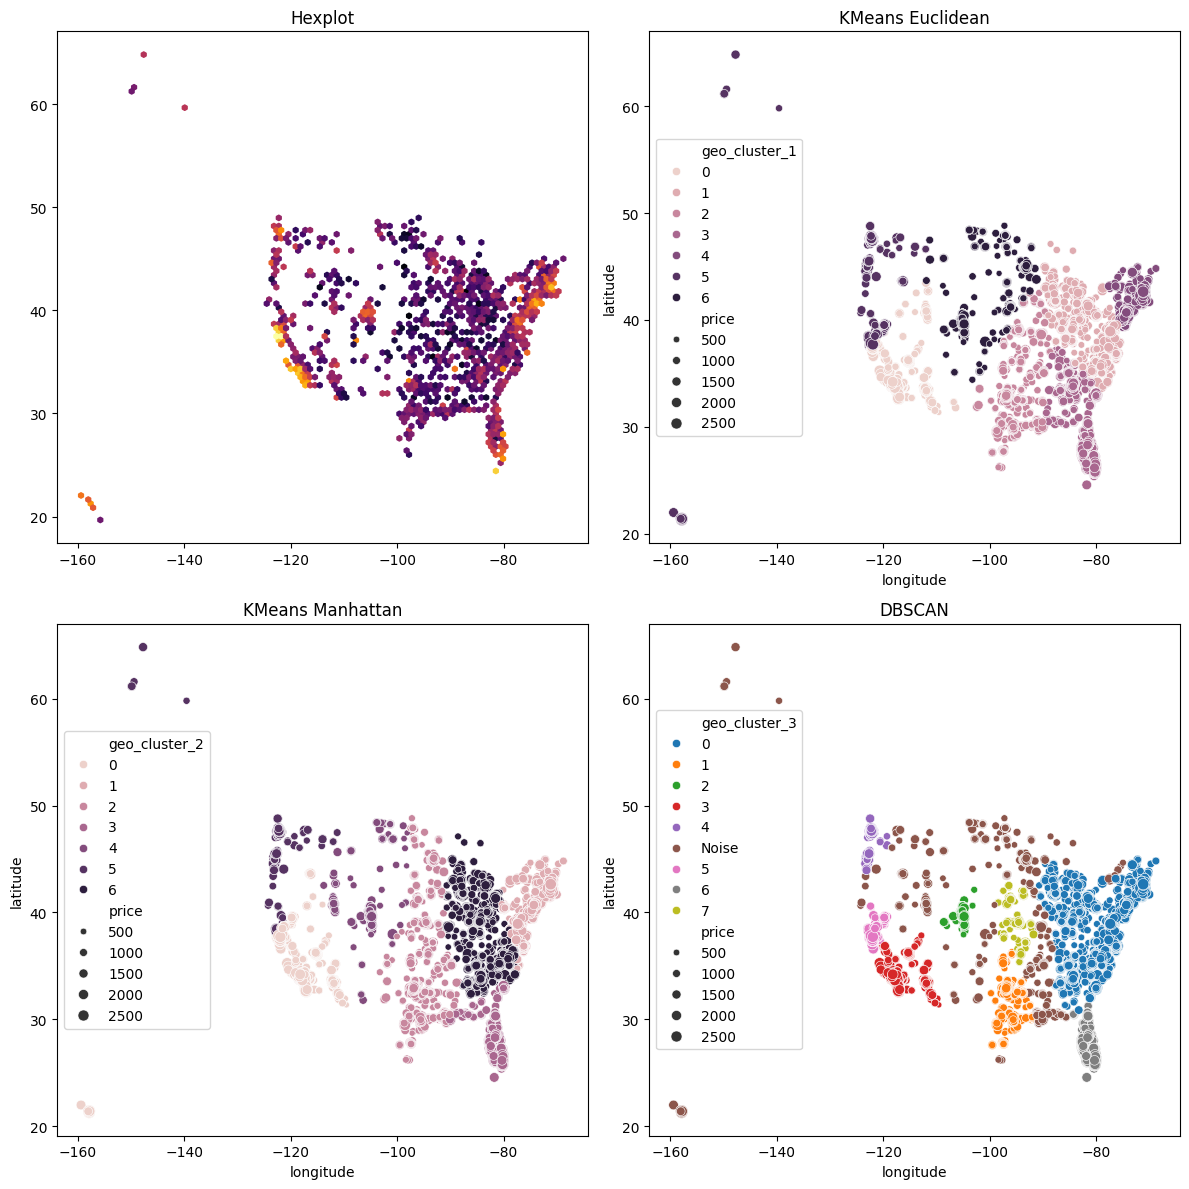

In [179]:
#Add cluster labels to original df
data['geo_cluster_3'] = clust_labels
data['geo_cluster_3'] = np.where(data['geo_cluster_3'] < 0,
                                 "Noise",
                                 data['geo_cluster_3'])
#Filter out points classified as noise
#data = df_rent[df_rent['geo_cluster_3'] != "Noise"]
#Show plot

#Show plot
fig, ax = plt.subplots(2, 2, figsize=(12, 12))
ax[0, 0].hexbin(df_rent["longitude"], df_rent["latitude"], gridsize = 100, cmap = 'inferno', mincnt = 1, C = df_rent["price"])
sns.scatterplot(ax=ax[0,1], x=data["longitude"], y=data["latitude"], size=data["price"], hue=data["geo_cluster_1"])
sns.scatterplot(ax=ax[1,0], x=data["longitude"], y=data["latitude"], size=data["price"], hue=data["geo_cluster_2"])
sns.scatterplot(ax=ax[1,1], x = data["longitude"], y = data["latitude"],size = data["price"], hue = data["geo_cluster_3"])

ax[0,0].set_title('Hexplot')
ax[0,1].set_title('KMeans Euclidean')
ax[1,0].set_title('KMeans Manhattan')
ax[1,1].set_title('DBSCAN')
plt.tight_layout()
plt.show()

#### Avaluació del model

Si comparem els resultats del DBSCAN amb els de la resta de models, en termes de mètriques és el que obté la pitjor puntuació en tots els casos. Pel coeficient de silhouette la diferència és poc significativa respecte del KMeans amb distància euclidianta però l'índex de Davies Bouldin quasi triplica els de la resta de models i l'índex de Calinski Harabasz és significativament menor, el que significa que els clusters no estan tan ben separats ni son tan compactes com en el cas dels models anteriors.

In [180]:
#Calculate metrics for best model and add them to the metrics df
silhouet = silhouette_score(data[["latitude","longitude"]], clust_labels)
dav_bould = davies_bouldin_score(data[["latitude","longitude"]], clust_labels)
cal_hara = calinski_harabasz_score(data[["latitude","longitude"]], clust_labels)

df_metrics["DBSCAN"] = [silhouet,dav_bould,cal_hara]

In [181]:
#Show metrics df
df_metrics

,Kmeans (euclid),Kmeans (Manhatt),DBSCAN
Silhouette,0.511926,0.538339,0.494205
Davies Bouldin,0.745586,0.588929,1.751567
Calinski Harabasz,107402.992706,107788.718438,46744.832746


### OPTICS
Com a darrer model no supervisat es s'aplicarà l'algorisme OPTICS a les dades. Amb aquest model hauria de ser més fàcil identificar millor clusters amb densitats diferents. Com a paràmetres, s'ha mantingut el nombre mínim d'observacions en 500 i s'ha considerat que el mínim d'observacions en cada cluster hauria de ser un 2% de les observacions, ja que amb valors més grans es generen menys grups dels que ens interessen. També resulta crucial determinar un valor de xi adequat, ja que aquest paràmetre determina la pendent mínima en el reachability plot que constitueix el límit dels clusters. Per fer-ho, s'ha creat un loop en el qual es calculen el nombre de grups, els punts considerats com a soroll i la mètrica silhouette per diferents valors de xi.

Segons els resultats obtinguts, el valor més adequat per xi és 0.05, en aquest cas es geneten 14 clusters i 14390 punts són classificats com a soroll.

In [182]:
#Import libraries
from sklearn.cluster import OPTICS

#Ev
for val in [0.01, 0.05, 0.1, 0.2]:
    opt = OPTICS(min_samples = 500, xi = val, min_cluster_size = 0.02)

    opt.fit(data[["latitude","longitude"]])
    clust_labels = opt.labels_
    n_clusters_ = len(set(clust_labels)) - (1 if -1 in clust_labels else 0)
    n_noise_ = list(clust_labels).count(-1)

    print(f"xi_val: {val}")
    print(f"Clusters: {n_clusters_}")
    print(f"Noise: {n_noise_}")
    print(f"Silhouette: {silhouette_score(data[["latitude","longitude"]], clust_labels)}")
    print("\n")

xi_val: 0.01
Clusters: 16
Noise: 13367
Silhouette: 0.27309700897373557


xi_val: 0.05
Clusters: 14
Noise: 14390
Silhouette: 0.2951114144753915


xi_val: 0.1
Clusters: 11
Noise: 18611
Silhouette: 0.14878183042185783


xi_val: 0.2
Clusters: 6
Noise: 28683
Silhouette: -0.2168538752990247




In [183]:
#Fit best
opt = OPTICS(min_samples = 500, xi = 0.05, min_cluster_size = 0.02)

opt.fit(data[["latitude","longitude"]])
clust_labels = opt.labels_
n_clusters_ = len(set(clust_labels)) - (1 if -1 in clust_labels else 0)
n_noise_ = list(clust_labels).count(-1)

En analitzar els mapes es pot observar que l'algorisme OPTICS classifica molts punts com a soroll, el que fa perdre molta informació rellevant. Tanmateix, és important remarcar que algunes àrees com les zones amb elevada densitat d'apartaments s'aconsegueixen identificar correctament i separar de les altres de manera distinctiva.

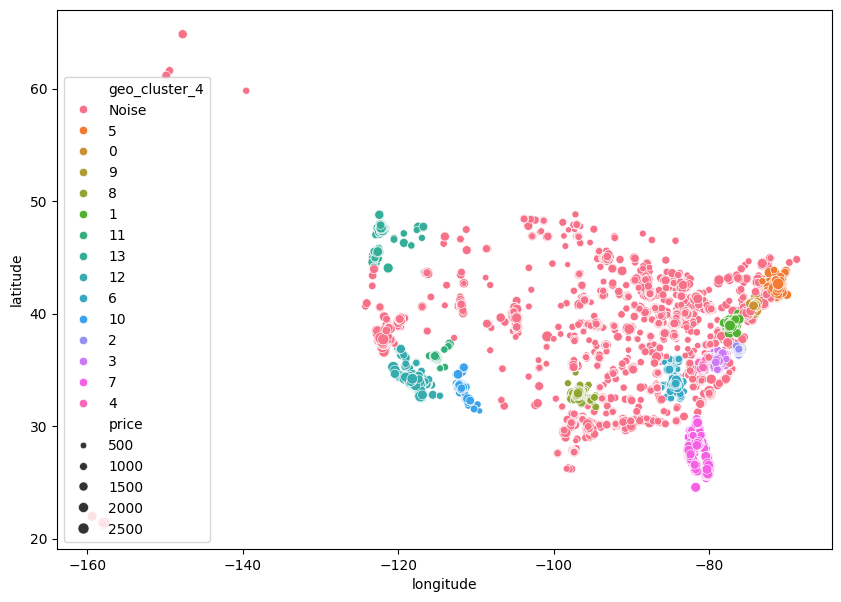

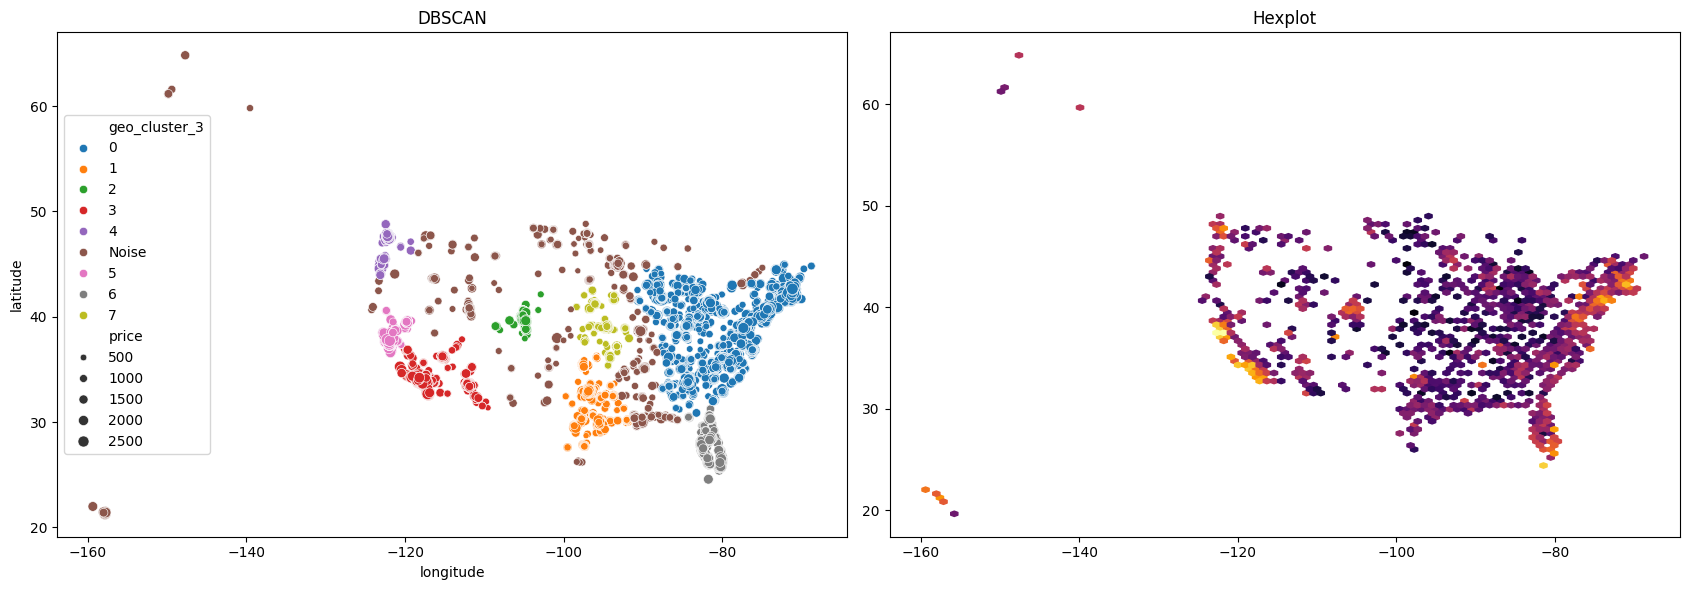

In [184]:
#Add cluster labels to original df
data['geo_cluster_4'] = clust_labels
data['geo_cluster_4'] = np.where(data['geo_cluster_4'] < 0,
                                 "Noise",
                                 data['geo_cluster_4'])

#Filter out points classified as noise
#data = data[data['geo_cluster_4'] != "Noise"]

#Show plots
plt.figure(figsize=(10, 7))
sns.scatterplot(x=data["longitude"], y=data["latitude"], size=data["price"], hue=data["geo_cluster_4"])
plt.show()

fig, ax = plt.subplots(1, 2, figsize=(17, 6))
plt.hexbin(df_rent["longitude"], df_rent["latitude"], gridsize = 100, cmap = 'inferno', mincnt = 1, C = df_rent["price"])
sns.scatterplot(ax=ax[0], x=data["longitude"], y=data["latitude"], size=data["price"], hue=data["geo_cluster_3"])
ax[1].set_title('Hexplot')
ax[0].set_title('DBSCAN')
plt.tight_layout()
plt.show()

#### Avaluació del model
En termes de mètriques numèriques l'OPTICS no aconsegueix superar la resta de models amb l'excepció del DBSCAN per l'índex Davies Bouldin. Tanmateix, s'ha de tenir en compte el que s'ha comentat durant l'anàlisi dels resultats gràfics. Tot i que aquest algorisme sembla poc apropiat per delimitar gran zones geogràfiques, pareix ser idoni per detectar i separar petits nuclis amb molta densitat d'ofertes. Això pot indicar que seria un bon candidat, si s'augmenta el nombre de clusters, per detectar amb precisió i diferenciar zones urbanes i altres localitzacions que poden presentar valors de preus distintius mentre que s'eliminen les zones amb poca densitat d'ofertes, que generalment tenen mitjanes de preus més baixos, classificant-les com a soroll.

In [185]:
#Calculate metrics for best model and add them to the metrics df
silhouet = silhouette_score(data[["latitude","longitude"]], clust_labels)
dav_bould = davies_bouldin_score(data[["latitude","longitude"]], clust_labels)
cal_hara = calinski_harabasz_score(data[["latitude","longitude"]], clust_labels)

df_metrics["OPTICS"] = [silhouet,dav_bould,cal_hara]

In [186]:
#Show metrics df
df_metrics

,Kmeans (euclid),Kmeans (Manhatt),DBSCAN,OPTICS
Silhouette,0.511926,0.538339,0.494205,0.295111
Davies Bouldin,0.745586,0.588929,1.751567,0.843642
Calinski Harabasz,107402.992706,107788.718438,46744.832746,9365.274990


## Models supervisats

### Introducció
En aquesta secció es creen i s'avaluen una sèrie de models supervisats de classificació basats en els arbres de decisió.

### Preparació de les dades
El primer pas que es realitzarà serà dividir les dades entre dos subconjunts. El primer es farà servir per entrenar el model i el segon per avaluar-lo. En aquest cas, un 80% de les dades s'utilitzaran per l'entrenament i un 20% per la validació. Aquests percentatges s'han triat 1) per evitar l'overfitting del model, una problemàtica que sorgiria si el percentatge de dades d'entrenament fos molt més gran que el de les d'avaluació, per exemple una divisió 99% - 1% i 2) per evitar entrenar un model esbiaixat i incapaç de generalitzar, el que ocorre quan les dades d'entrenament són insuficientment grans.

Pel que fa a la variable objectiu aquesta seran les classes de preu i com a variables explicatives inclourem el nombre de banys, el de llits, els metres quadrats i el total de serveis amb que compta l'apartament. S'ha optat per incloure només aquestes variables per no sobrecomplicar el model i facilitar la interpretació de les normes generades pel model.

In [187]:
#Import libraries
from sklearn.model_selection import train_test_split

#Split data
y = data["price_bins"]
x = data[["bathrooms", "bedrooms", "square_m", "total_amenities"]]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3)
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(28000, 4)
(12000, 4)
(28000,)
(12000,)


### Arbre de decisió sense poda
En segon lloc, es crearà el primer model supervisat que serà una arbre de decisió per classificar les observacions entre les de preu elevat, mitjà-alt, mitjà i baix. En aquest cas s'ha limitat la profunditat de l'arbre de decisió a 4 nivells per tal de simplificar la representació visual de l'arbre i l'extracció de les normes de decisió. 

In [188]:
#Import libraries
from sklearn import tree

#Create model
model1 = tree.DecisionTreeClassifier(max_depth = 4, criterion = "gini", random_state = 222)

#Fit data to the model
model1.fit(x_train,y_train)

DecisionTreeClassifier(max_depth=4, random_state=222)

A continuació es pot observar la representació gràfica de l'arbre de decisió. Tanmateix, com que l'arbre és bastant gran, s'ha extret amb alta resolució i es recomana consultar-lo al fitxer .png que s'ha entregat juntament amb la pràctica. També es presenten les normes de decisió de l'arbre en format text per facilitar-ne la lectura.

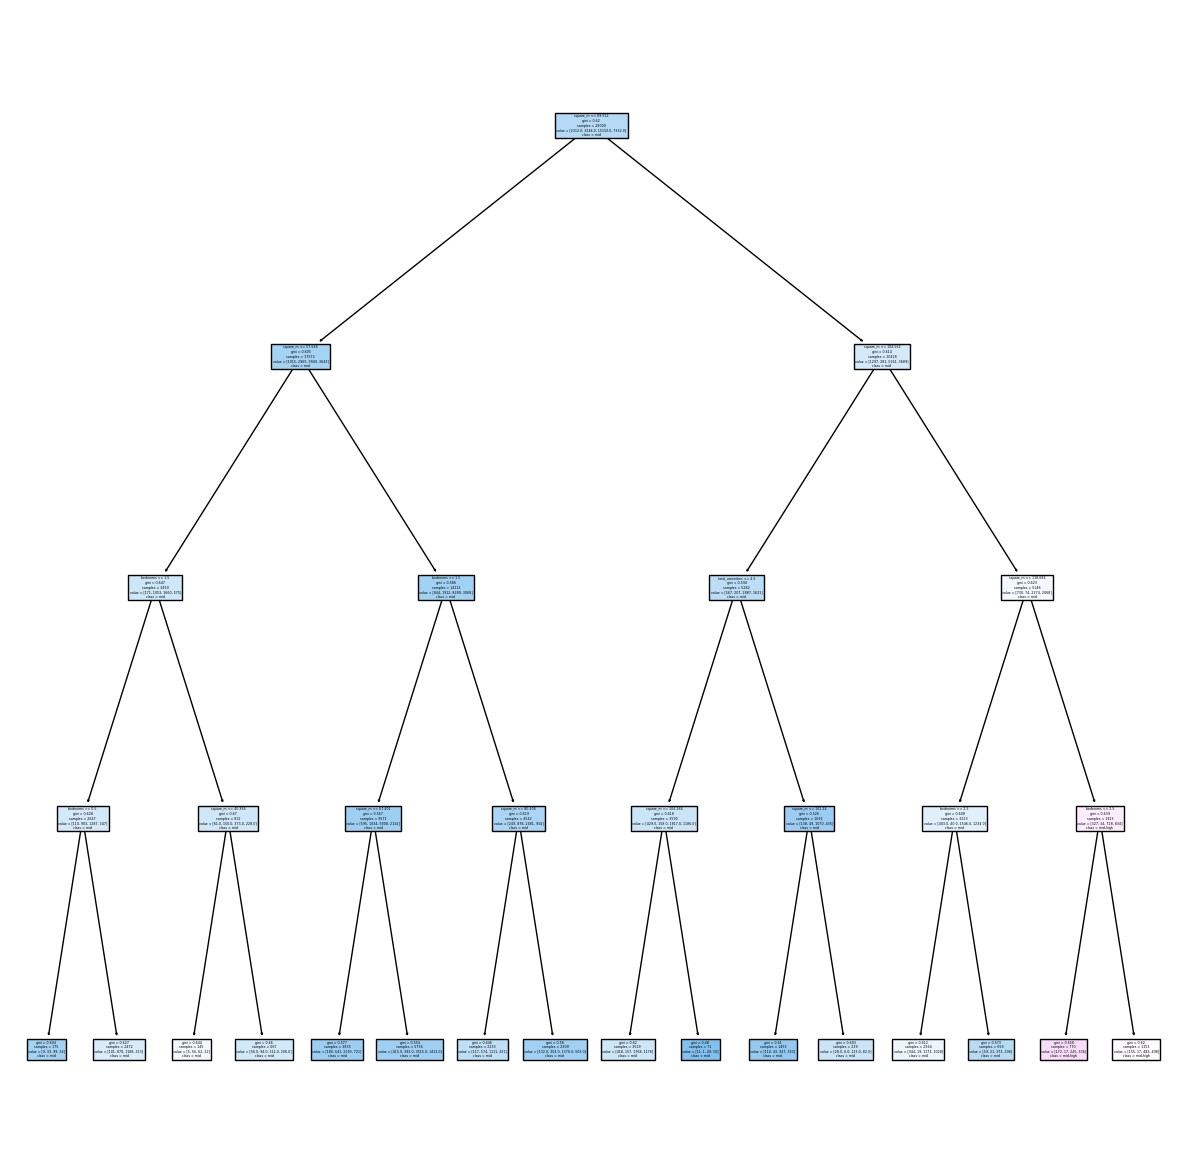

In [189]:
plt.figure(figsize=(15, 15))

tree.plot_tree(model1, 
                   feature_names = ["bathrooms", "bedrooms", "square_m", "total_amenities"],  
                   class_names = model1.classes_,
                   filled = True)

plt.savefig('tree_plot.png', dpi=300)

plt.show()


Si analitzem els resultats del model s'observa que la variable metres quadrats és la mètrica elegida pel model, segons l'índex d'impuresa de gini per realitzar els dos primers splits. Això indica que aquesta variable resulta de les més eficaces per dividir les dades en classes de preus diferents. És un resultat coherent amb el sentit comú, ja que els apartaments més grans acostumen a tenir preus més elevats.

In [190]:
from sklearn.tree import export_text
rules = export_text(model1, feature_names=["bathrooms", "bedrooms", "square_m", "total_amenities"])

print(rules)

|--- square_m <= 89.51
|   |--- square_m <= 57.65
|   |   |--- bedrooms <= 1.50
|   |   |   |--- bedrooms <= 0.50
|   |   |   |   |--- class: mid
|   |   |   |--- bedrooms >  0.50
|   |   |   |   |--- class: mid
|   |   |--- bedrooms >  1.50
|   |   |   |--- square_m <= 40.37
|   |   |   |   |--- class: mid
|   |   |   |--- square_m >  40.37
|   |   |   |   |--- class: mid
|   |--- square_m >  57.65
|   |   |--- bedrooms <= 1.50
|   |   |   |--- square_m <= 67.40
|   |   |   |   |--- class: mid
|   |   |   |--- square_m >  67.40
|   |   |   |   |--- class: mid
|   |   |--- bedrooms >  1.50
|   |   |   |--- square_m <= 80.41
|   |   |   |   |--- class: mid
|   |   |   |--- square_m >  80.41
|   |   |   |   |--- class: mid
|--- square_m >  89.51
|   |--- square_m <= 104.56
|   |   |--- total_amenities <= 4.50
|   |   |   |--- square_m <= 104.28
|   |   |   |   |--- class: mid
|   |   |   |--- square_m >  104.28
|   |   |   |   |--- class: mid
|   |   |--- total_amenities >  4.50
|   |   

### Avaluació del model
El fet de trobar-nos davant d'un model de classificació múltiple complica el càlcul de les mètriques d'avaluació com la precisió, la sensibilitat o l'índex F1, ja que s'han de tenir en compte les relacions entre múltiples variables. En aquet cas s'ha optat per calcular aquestes mètriques de manera que consisteixin en la puntuació mitjana de cada puntuació pel conjunt de classes, en aquest cas, quatre.

Durant la fase d'avaluació, principalment a través de la matriu de confusió, s'ha detectat que el model presentava un biaix, és a dir, que tendia a classificar la majoria d'observacions com a de preu mitjà. Per adreçar la problemàtica s'ha tret la restricció sobre els 4 nivells de profunditat creada per facilitar l'anàísi gràfica del model. A continuació s'ha tornat a crear el model i es presenta la nova matriu de confusió, juntament amb les mètriques calculades.

/home/JM/Desktop/Political Watch/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


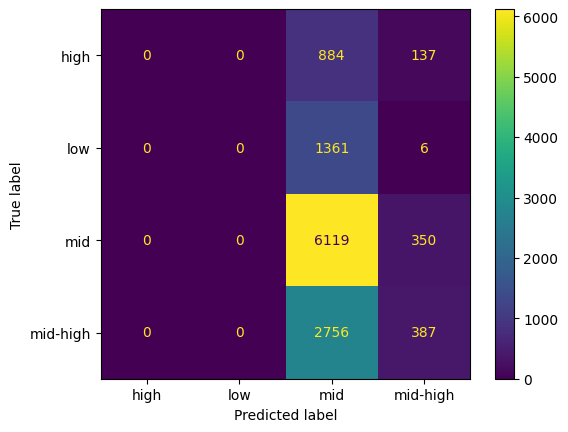

In [191]:
#Import libaries
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, RocCurveDisplay, ConfusionMatrixDisplay

#Make predictions
predictions = model1.predict(x_test)

#Calculate accuracy score
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions, average='macro')
recall = recall_score(y_test, predictions, average='macro')
f1 = f1_score(y_test, predictions, average='macro')

#Store in df
df_metrics2 = pd.DataFrame([accuracy,precision,recall,f1], columns = ["Arbre de decisió (sense poda)"], index = ["Accuracy", "Precisió", "Sensibilitat", "F1"])

#Plot Confusionmatrix
ConfusionMatrixDisplay(confusion_matrix(y_test, predictions), display_labels = model1.classes_).plot()

In [192]:
#Create model
model2 = tree.DecisionTreeClassifier(random_state = 333)

#Fit data to the model
model2.fit(x_train,y_train)

DecisionTreeClassifier(random_state=333)

Amb el nou model, es pot comprovar que la qualitat de les prediccions ha millorat significativament. El model encara presenta defectes, ja que tendeix a classificar com a ofertes de preu mitjà les de preu mitjà-elevat, així com les de preu baix. També es confon sovint entre les observacions de preu mitjà alt i les de preu mitjà. Com a punt fort, aquest arbre de decisió eś capaç de detectar correctament els true positives (TP) de preu mitjà i en menor grau els TP de preu mitjà-alt.

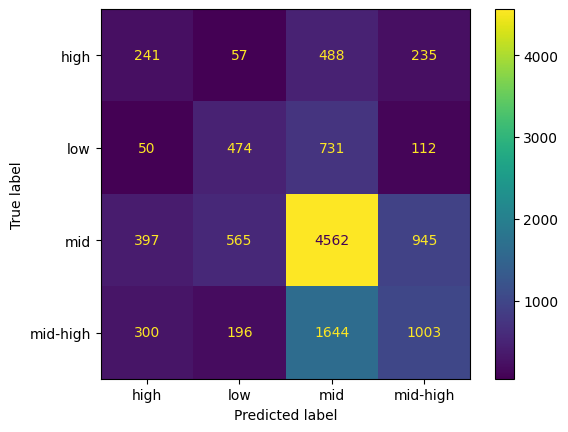

In [193]:
#Make predictions
predictions = model2.predict(x_test)

#Calculate accuracy score
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions, average='macro')
recall = recall_score(y_test, predictions, average='macro')
f1 = f1_score(y_test, predictions, average='macro')

#Store in df
df_metrics2["Arbre de decisió 2 (sense poda)"] = [accuracy,precision,recall,f1]

#Plot Confusionmatrix
ConfusionMatrixDisplay(confusion_matrix(y_test, predictions), display_labels = model2.classes_).plot()

Com és d'esperar si avaluem les mètriques numèriques, en augmentar la produnditat de l'arbre, totes les mètriques d'avaluació han millorat amb l'excepció de l'accuracy, és a dir, la proporció de mètriques correctament classificades, que s'ha reduït lleument. Això és probablement degut a que la sobrerepresentació d'ofertes de preu mitjà fa que un model esbiaixat que classifiqui la gran majoria d'observacions com a membres de la classe majoritària pugui obtenir puntuacions molt elevades en aquest tipus de mètriques.

In [194]:
df_metrics2

,Arbre de decisió (sense poda),Arbre de decisió 2 (sense poda)
Accuracy,0.542167,0.523333
Precisió,0.247511,0.415562
Sensibilitat,0.267257,0.401780
F1,0.222042,0.405504


### Arbres de decisió amb poda
En aquest apartat es parteix del segon model creat anteriorment i se li aplica una poda mitjançant el mètode de Cost-Complexity, que evalua cada branca de l'arbre de decisió original en base a la seva complexitat i accuracy i selecciona les més òptimes. La poda permet reduir el nombre de branques i nodes de l'arbre reduint-ne la complexitat sense empitjorar la seva capacitat predictiva. Es millora així el rendiment i la interpretabilitat del model.

El parámetre més important per fer la poda és el ccp_alpha, que controla la complexitat de l'arbre de decisió. Com major sigui aquest paràmetre, menor serà l'arbre resultant, ja que tindrà menys nodes. Per trobar un valor apropiat s'ha fet un gràfic per avaluar com augmenta la impuresa amb diferents valors de ccp:_alpha. En el nostre cas la impuresa incrementa molt ràpidament per valors d'alpha molt petits.

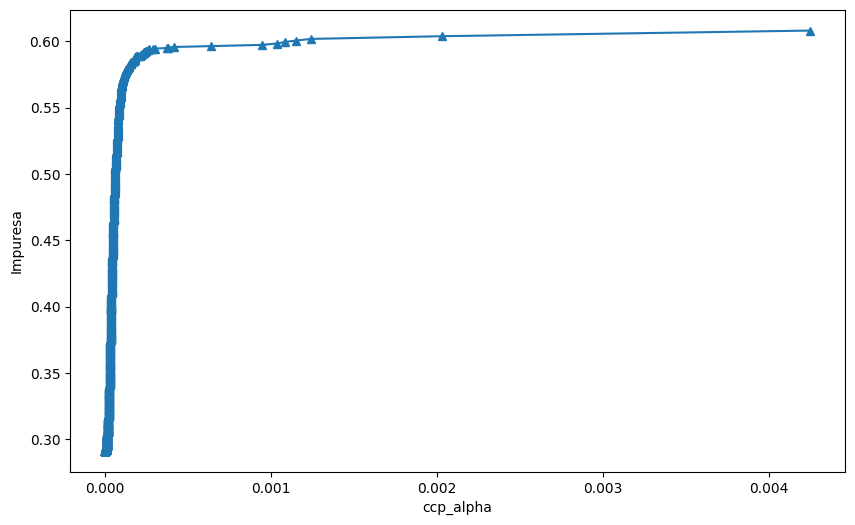

In [195]:
prun_path = model2.cost_complexity_pruning_path(x_train, y_train)
ccp_alphas, impurities = prun_path.ccp_alphas, prun_path.impurities

#Plot alphas vs impurity
plt.figure(figsize=(10, 6))
plt.plot(ccp_alphas[:-1], impurities[:-1], marker='^')
plt.xlabel("ccp_alpha")
plt.ylabel("Impuresa")
plt.show()


A partir del gràfic i de l'avaluació del nombre de nodes de l'arbre després de la poda s'ha determinat que un valor d'alpha de 0.00003, aconseguia reduir significativament la complexitat de l'arbre sense incrementar en excés la impuresa i perjudicar la capacitat predictiva del model. A continuació es pot comprovar que els nodes de l'arbre abans i després de la poda s'han reduit de 17393 a 8417, quasi a la meitat.

In [196]:
#Choosing appropriate alpha
ccp_alpha = 0.00003

#Create new model
model3 = tree.DecisionTreeClassifier(ccp_alpha = ccp_alpha, random_state=  666)
model3.fit(x_train, y_train)

#Make predictions
predictions = model3.predict(x_test)

#Number of nodes
print(f" Nodes del model sense poda: {model2.tree_.node_count}\n Nodes del model amb poda: {model3.tree_.node_count}")

 Nodes del model sense poda: 17621
 Nodes del model amb poda: 8681


### Avaluació del model
El model amb poda presenta una matriu de confusió molt similar a la del model sense poda, els punts forts i els punts febles del model segueixen essent els mateixos.

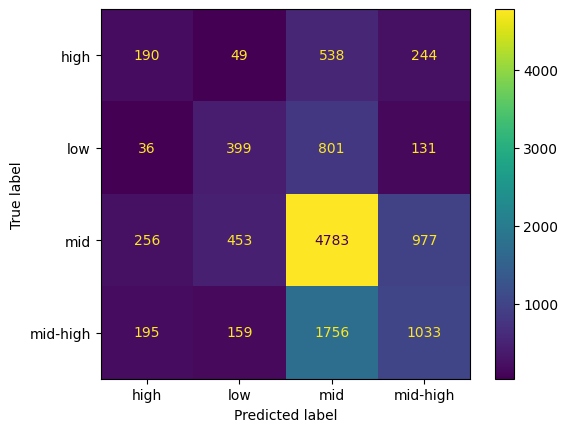

In [197]:
#Calculate accuracy score
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions, average='macro')
recall = recall_score(y_test, predictions, average='macro')
f1 = f1_score(y_test, predictions, average='macro')

#Store in df
df_metrics2["Arbre de decisió (amb poda)"] = [accuracy,precision,recall,f1]

#Plot Confusionmatrix
ConfusionMatrixDisplay(confusion_matrix(y_test, predictions), display_labels = model3.classes_).plot()

En analitzar les mètriques numèrriques s'observa que la proporció d'observacions correctament classificades (accuracy) ha augmentat pel model amb poda. Com s'ha esmentat abans, és possible que això simplement es degui a la major proporció de mètriques de preu mitja. Pel que fa a la precisió, és a dir, a la capacitat d'identificar els true positives respecte de totes les observacions classificades com a membres d'una classe específica del model, aquesta també s'ha incrementat. Si avaluem la sensibilitat, que representa la qualitat del model per identificar true positives respecte de totes les observacions que pertanyen realment a una classe específica, aquesta ha baixat encara que de manera pot significativa. El mateix passa amb l'índex F1, que harmonitza les mètriques de precisió i sensibilitat en una de sola, aquesta és lleugerament menor que en el cas de l'arbre sense poda.

In [198]:
df_metrics2

,Arbre de decisió (sense poda),Arbre de decisió 2 (sense poda),Arbre de decisió (amb poda)
Accuracy,0.542167,0.523333,0.533750
Precisió,0.247511,0.415562,0.424331
Sensibilitat,0.267257,0.401780,0.386503
F1,0.222042,0.405504,0.398272


### Gradient boosting
Per provar un efocament algorítmic diferent que no s'allunyi massa dels arbres de decisió, s'ha optat per crear un model de gradient boosting. Aquests models es poden considerar una generalització dels d'adaptive boosting i també es basen en els arbres de decisió. La forma en la qual funciona l'algorisme és anar iterant i millorant els arbres de decisió a partir de crear nous models enfocats a corregir els errors dels anteriors.

A continuació es crear un exemple d'aquests models i es comparen els resultats amb els dels anteriors.

In [199]:
#Import libraries
from sklearn.ensemble import GradientBoostingClassifier

#Create model 4
model4 = GradientBoostingClassifier(random_state = 665)
model4.fit(x_train,y_train)

#Make predictions
predictions = model4.predict(x_test)

### Avaluació del model
Si analitzem la matriu de confusió resulta fàcil observar que el model de gradient boosting presenta un clar biaix, ja que classifica la majoria d'observacions com a de preu mitjà. Com hem anat veient, aquest és un dels principals problemes que presenta el conjunt de dades.

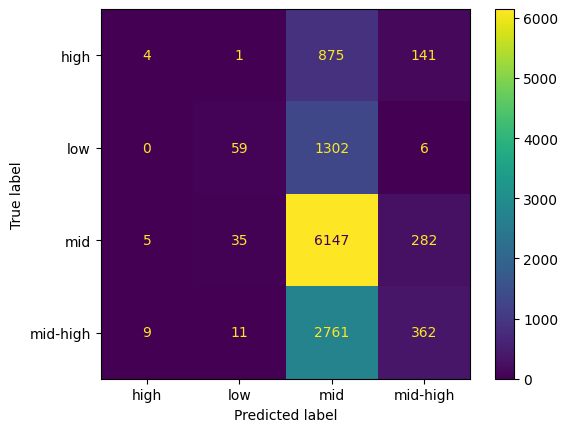

In [200]:
#Calculate accuracy score
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions, average='macro')
recall = recall_score(y_test, predictions, average='macro')
f1 = f1_score(y_test, predictions, average='macro')

#Store in df
df_metrics2["Gradient Boosting"] = [accuracy,precision,recall,f1]

#Plot Confusionmatrix
ConfusionMatrixDisplay(confusion_matrix(y_test, predictions), display_labels = model4.classes_).plot()

Si es comparen les mètriques numèriques pels tres models, el gradient boosting és el que obté la millor accuracy i precisió. Tanmateix, la sensibilitat és la més baixa exceptuant el primer arbre de decisió sense poda. Això ens informa de que, quan el model assigna observacions a una classe concreta, tendeix a identificar correctament els true positives (TP). Tanmateix, si es considera la proporció de TP correctament identificats respecte del total de valors que realment pertanyen a una classe, la puntuació és molt menor. En resum, es pot concloure que el model comet més errors en termes de falsos negatius que de falsos positius quan s'avalua la mitjana d'aquestes mètriques per totes les classes. Finalment, si s'examina l'índex F1, que permet una anàlisi en conjunt de la sensibilitat i la precisió s'observa que aquesta també és la més baixa després del primer arbre de decisió sense poda.

In [201]:
df_metrics2

,Arbre de decisió (sense poda),Arbre de decisió 2 (sense poda),Arbre de decisió (amb poda),Gradient Boosting
Accuracy,0.542167,0.523333,0.533750,0.547667
Precisió,0.247511,0.415562,0.424331,0.447752
Sensibilitat,0.267257,0.401780,0.386503,0.278120
F1,0.222042,0.405504,0.398272,0.243050


## Conclusió
Al llarg d'aquesta pràctica s'han aplicat diversos models supervisats i no supervisats per analitzar un conjunt de dades d'ofertes de lloguers d'arreu dels Estats Units. Durant el modelatge de les dades s'ha detectat que existien algunes limitacions relacionades amb el conjunt de dades utilitzat.

En el cas dels models no supervisats, quan s'ha intentat classificar les observacions en grans zones geogràfiques amb diferents preus mitjans, ens hem trobat amb el fet que la gran dispersió de les observacions arreu del territori dels Estats Units dificultava aquesta tasca, especialment a causa de l'existència de zones remotes com Hawaii o Alaska. Això no obstant, un resultat remarcable ha estat el potencial de l'algorisme OPTICS per acomplir aquesta tasca tot i les baixes puntuacions obtingudes en les mètriques d'avaluació. Això es deu al fet que aquesta tècnica permet classificar com a soroll els punts amb menys densitat d'ofertes, que resulten ser els de preus mitjans més baixos a la vegada que identifica de manera distintiva els nuclis urbans o amb molta aglomeració d'ofertes, que resulten ser aquells amb preus més elevats. Així i tot, l'elevat nombre de clústers que genera sobrecompliquen significativament el model.

Pel que fa als models supervisats, com s'ha identificat durant el modelatge de les dades, la principal limitació ha estat la sobrerepresentació d'observacions del tipus preu mitjà. Aquesta casuística ha provocat que alguns models presentessin biaixos que s'han intentat adreçar amb l'afinament de diversos paràmetres. Tanmateix, és possible que per millorar la capacitat predictiva dels models calgui aplicar més transformacions al joc de dades original per intentar extreure un subconjunt de dades amb proporcions més equilibrades per cada una de les classes. Algunes altres limitacions estan relacionades amb la mida del conjunt de dades, que s'ha hagut de reduir a la meitat per temes d'eficiència computacional i per reduir la complexitat dels models, així com per millorar-ne la interpretabilitat com en el cas de les normes generades pels arbres de decisió.

Finalment, en termes de riscs associats a fer servir el model, són els que s'han anat esmentant més amunt. En primer lloc, en el cas dels models no supervisats de classificació geogràfica s'ha arribat a la conclusió que les particularitats de la tasca feien que l'anàlisi gràfica fos una eina més efectiva per identificar els millors models que l'avaluació d'aquests mitjançant mètriques numèriques, especialment en el cas dels algorismes basats en densitat. Pel que fa a l'ús de models supervisats per classificar les ofertes segons la seva categoria de preus, els valors de les mètriques analitzades són bastant baixos i no permeten afirmar que s'hagi aconseguit elaborar un model de classificació fiable i efectiu. A més, alguns dels models creats presentaven clars biaixos, ja que aplicaven de manera indiscriminada la norma de classificar les observacions en la categoria de preu mitjà per acomodar la sobrerepresentació d'aquestes en el joc de dades.